
<a href="https://colab.research.google.com/github/JoaoGranja/Semantic_Segmentation/blob/master/semantic_segmentation_main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
is_colab = True


# **Colab Preparation** 
Before starting to approach the project, we need to install tensorflow/keras and pip packages. I also share my google drive to simplify the connection with my google drive account where other modules are hosted.



In [ ]:
if is_colab:
    #Package Installation and share Google Drive
    !pip install --upgrade pip
    #!pip install --upgrade keras
    !pip install keras-resnet
    !pip install tensorflow==2.4.0
    !pip install tensorflow-gpu==2.4.0
    !pip install tensorflow_addons
    !pip install keras==2.4

    !pip install keras-segmentation

    from google.colab import drive
    drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


 # **Configuration and imports**

After installing all packages necessary for this project, we have to import the required modules. I also use some configuration parameters to provide more flexibility to the tranining and evaluation process. It is important to note that we should only evaluate and compare networks performance, after training all networks.

In this project I will be making use of the Keras library for creating our model and training it. I will also use Matplotlib for visualizing our dataset to gain a better understanding of the images we are going to be handling.



In [ ]:
# Generic Imports
import time
import gc
import logging, os
import sys
import random
import warnings
import pickle
from math import ceil
from tqdm import tqdm
from itertools import chain

# data processing and visualization library
import numpy as np
import pandas as pd
#import seaborn as sns
from IPython.display import clear_output
import matplotlib.pyplot as plt
import cv2 

# tensorflow and keras for DL model
import tensorflow
import tensorflow as tf
import tensorflow_datasets as tfds
#logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

from tensorflow.keras.models import Model, save_model, load_model, Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from tensorflow.keras.optimizers import RMSprop, Adam, SGD
from tensorflow.keras import backend as K
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.utils import to_categorical, plot_model
#from keras.utils import multi_gpu_model
from tensorflow.keras.preprocessing.image import Iterator, load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.layers.experimental import preprocessing

if is_colab:
    from google.colab import files
    sys.path.append('/content/drive/MyDrive/colab/Semantic_Segmentation')
    os.chdir('/content/drive/MyDrive/colab/Semantic_Segmentation')
    
#------------------------------  Set some configuration parameters -----------------------------------#
args = {}
args['seed'] = 42
args['training'] = False
args['fine_tuning'] = False
args['evaluation_networks'] = True
args['debug'] = False

#training arguments
args['train_epochs'] = 10
args['fine_tune_epochs'] = 5

#model arguments
args['compare_networks'] = ['mobileNetV2_Unet', 'mobilenet_fcn_8',
                            'mobileNetV2_pspnet', 'mobileNetV2_segnet', 'Deeplabv3']
                          
args['network'] = 'mobileNetV2_segnet'
args['models_dir'] = 'nn_models_checkpoints'

#optimizer arguments
args['optimizer'] = 'adam'
#args['weights'] = 'nn_models_checkpoints/best_{}.h5'.format(args['networks'][0])
args['learning_rate'] = 0.001
args['decay'] = 0.0001
args['loss'] = SparseCategoricalCrossentropy(from_logits=True)


warnings.filterwarnings('ignore', category=UserWarning, module='skimage')

# **Loading the dataset**

In this project I will use the Oxford-IIIT pet dataset directly imported from tensorflow dataset API. This dataset is a 37 category pet image dataset with roughly 200 images for each class. The images have large variations in scale, pose and lighting. All images have an associated ground truth annotation of breed. More information is available on [Oxford-IIT dataset homepage](https://www.tensorflow.org/datasets/catalog/oxford_iiit_pet)


# **Data pre-processing and data augmentation**
Using the tensorflow_datasets API, I will import the Oxford-IIIT pet dataset. Because the images don't have the same size, I will resize all images and segmentation mask to (128,128) or (192,192) or (224,224) size and then normalize both image and mask. The images size will depend on model chosen. Finally I will perform some data augmentation in order that the model can better generalize to the testing dataset.

This dataset will be handled as tensorflow dataset so it is important to preprocess it to speed up its use. So as it is suggested on tensorflow API documentation, I combine consecutive elements of this dataset into batches, cache, shufle and prefetch the elements.

In [ ]:
if args['network'] == 'mobileNetV2_pspnet':
  INPUT_SHAPE = [192,192,3]
elif args['network'] == 'mobileNetV2_Unet':
  INPUT_SHAPE = [224,224,3]
else:
  INPUT_SHAPE = [128,128,3]
  
def normalize(image, label):
  image = tf.cast(image, tf.float32) / 255.0
  label -= 1
  return image, tf.cast(label, tf.float32)

def load_image(datapoint):
  input_image = tf.image.resize(datapoint['image'], (INPUT_SHAPE[0], INPUT_SHAPE[1]))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (INPUT_SHAPE[0], INPUT_SHAPE[1]))

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

class Augment(tf.keras.layers.Layer):
  def __init__(self, seed=42):
    super().__init__()
    # both use the same seed, so they'll make the same randomn changes.
    self.augment_images = tf.keras.Sequential([preprocessing.RandomFlip(mode="horizontal", seed=seed),
    ])
    self.augment_labels = tf.keras.Sequential([preprocessing.RandomFlip(mode="horizontal", seed=seed),
    ])
    #preprocessing.RandomRotation(0.2, seed=seed),
    #preprocessing.RandomZoom((0.2, 0.3), seed=seed),

  def call(self, inputs, labels):
    inputs = self.augment_images(inputs)
    labels = self.augment_labels(labels)
    return inputs, labels

In [ ]:
#------------------------------  Load dataset using tf.dataset API -----------------------------------#
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)
train_images = dataset['train'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
val_images = dataset['test'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)


# Some parameters for the dataset batches
BATCH_SIZE = 64
BUFFER_SIZE = 1000
OUTPUT_CLASSES = 3
STEPS_PER_EPOCH = info.splits['train'].num_examples // BATCH_SIZE
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples //BATCH_SIZE//VAL_SUBSPLITS


# Create Train and Validation Batches
train_batches = (
    train_images
    .cache()                                 # The first time the dataset is iterated over, its elements will be cached either in the specified file or in memory. Subsequent iterations will use the cached data
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)                       # Combines consecutive elements of this dataset into batches.
    .repeat()                                # Repeats this dataset so each original value is seen count times.
    .map(Augment())
    .prefetch(buffer_size=tf.data.AUTOTUNE)) # This allows later elements to be prepared while the current element is being processed.

val_batches = val_images.batch(BATCH_SIZE)

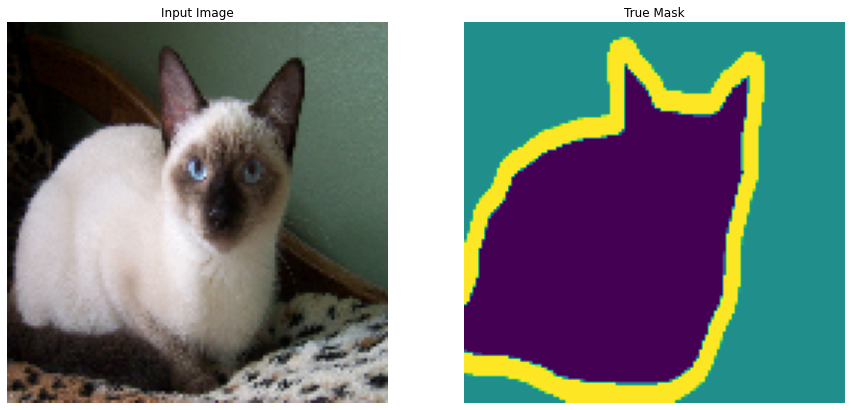

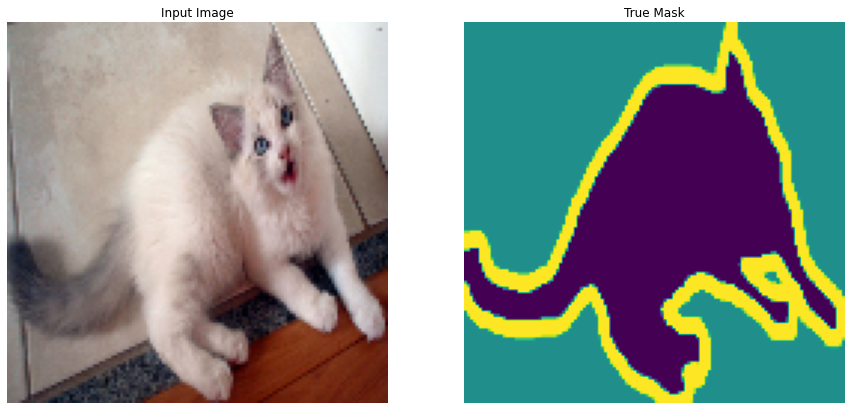

In [ ]:
#------------------------------ Plot random images and respective true mask -----------------------------------#
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

for images, masks in train_batches.take(2):
  sample_image, sample_mask = images[0], masks[0]
  display([sample_image, sample_mask])


Analyzing the pair images and true mask, it is clear that the mask output range is [0,2]. One colour (kind of blue) is for the background, other color(purple) for the animal (dog or cat) and the last one (yellow) for the animal boundary.

# **Optimizer**

Before training it is necessary to choose an optimizer which will be responsible to adjust model parameters in order to reduce the loss funcion

In [ ]:
#------------------------------ Define an optimizer -----------------------------------#
if 'optimizer' in args:
    if args['optimizer'] == 'rmsprop':
        optimizer = RMSprop(learning_rate=args['learning_rate'], decay=float(args['decay']))
    elif args['optimizer'] == 'adam':
        optimizer = Adam(learning_rate=args['learning_rate'], decay=float(args['decay']))
    elif args['optimizer'] == 'amsgrad':
        optimizer = Adam(learning_rate=args['learning_rate'], decay=float(args['decay']), amsgrad=True)
    elif args['optimizer'] == 'sgd':
        optimizer = SGD(learning_rate=args['learning_rate'], momentum=0.9, nesterov=True, decay=float(args['decay']))
else:
    optimizer = RMSprop(learning_rate=args['learning_rate'])

# **Metric**

When we are training a model for a semantic segmentation project, it is usefull to compute the Intersection over Union (IoU). It is a number from 0 to 1 that specifies the amount of overlap between the predicted and ground truth mask.

*   an IoU of 0 means that there is no overlap between the masks
*   an IoU of 1 means that the union of the masks is the same as their overlap indicating that they are completely overlapping 

In [ ]:
def my_metric_fn(y_true, y_pred):
  n_classes=3
  tp = np.zeros(n_classes)
  fp = np.zeros(n_classes)
  fn = np.zeros(n_classes)
  n_pixels = np.zeros(n_classes)
  pred_mask = tf.argmax(y_pred, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  pred_mask = pred_mask[0]
  mask = y_true[0]
  mask_np = mask.numpy().flatten()
  pred_mask_np = pred_mask.numpy().flatten()
  
  for cl_i in range(n_classes):

      tp[cl_i] += np.sum((pred_mask_np == cl_i) * (mask_np == cl_i))
      fp[cl_i] += np.sum((pred_mask_np == cl_i) * ((mask_np != cl_i)))
      fn[cl_i] += np.sum((pred_mask_np != cl_i) * ((mask_np == cl_i)))
      n_pixels[cl_i] += np.sum(mask_np == cl_i)

  cl_wise_score = tp / (tp + fp + fn + 0.000000000001)
  n_pixels_norm = n_pixels / np.sum(n_pixels)
  frequency_weighted_IU = np.sum(cl_wise_score*n_pixels_norm)
  mean_IU = np.mean(cl_wise_score)

  return  tf.convert_to_tensor(mean_IU)

# **Model**

In this project, I will compare the performance of several semantic segmentation model architectures. The architectures used in this project are based on an Encoder-Decoder structure. First, the encoder outputs a tensor containing information about the objects, and its shape and size. Then the decoder takes this information and produces the segmentation maps. The models architectures used in this case are: 

*   Unet
*   FCN
*   DeepLabv3
*   Pspnet
*   Segnet

Definition of these models are coded on a separate module (models).

In [ ]:
from models.model_factory import make_model
from models.mobilenet import relu6

if args['training']:
  #------------------------------ Make the model -----------------------------------#
  model = make_model(args['network'], INPUT_SHAPE, OUTPUT_CLASSES)

  if 'weights' not in args:
      print('No weights passed, training from scratch')
  else:
      print('Loading weights from {}'.format(args['weights']))
      model.load_weights(args['weights'], by_name=True)

  #------------------------------ Compile the model -----------------------------------#
  model.compile(loss=args['loss'], optimizer=optimizer, metrics=['accuracy', my_metric_fn]) 

if args['debug']:
  model.summary()

Using TensorFlow backend.


In [ ]:
if args['debug']:
  plot_model(model, show_shapes=True)

# **Training**

This step called trainig comprises on fitting the model parameters to correctly classify each pixel in the images. For that, the optimizer uses a loss function to quantify the discrepance between true and predicted masks. Based on that it adjusts the model parameters to decrease the loss. Model checkpoints, EarlyStopping and Learning Rate reduce are used as callbacks to improve training efficiency.

In [ ]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

def evalute_IoU(n_classes, dataset, num = 1):
  tp = np.zeros(n_classes)
  fp = np.zeros(n_classes)
  fn = np.zeros(n_classes)
  n_pixels = np.zeros(n_classes)
  for image, mask in dataset.take(num):
    pred_mask = model.predict(image)
    pred_mask = create_mask(pred_mask)
    mask = mask[0]
    mask_np = mask.numpy().flatten()
    pred_mask_np = pred_mask.numpy().flatten()
    
    for cl_i in range(n_classes):
        tp[cl_i] += np.sum((pred_mask_np == cl_i) * (mask_np == cl_i))
        fp[cl_i] += np.sum((pred_mask_np == cl_i) * ((mask_np != cl_i)))
        fn[cl_i] += np.sum((pred_mask_np != cl_i) * ((mask_np == cl_i)))
        n_pixels[cl_i] += np.sum(mask_np == cl_i)

  cl_wise_score = tp / (tp + fp + fn + 0.000000000001)
  n_pixels_norm = n_pixels / np.sum(n_pixels)
  frequency_weighted_IU = np.sum(cl_wise_score*n_pixels_norm)
  mean_IU = np.mean(cl_wise_score)

  return {
        "frequency_weighted_IU": frequency_weighted_IU,
        "mean_IU": mean_IU,
        "class_wise_IU": cl_wise_score
    }


class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    #clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))


def add_sample_weights(image, label):
  # The weights for each class, with the constraint that:
  #     sum(class_weights) == 1.0
  class_weights = tf.constant([1.0, 2.0, 3.0])
  class_weights = class_weights/tf.reduce_sum(class_weights)

  # Create an image of `sample_weights` by using the label at each pixel as an 
  # index into the `class weights` .
  sample_weights = tf.gather(class_weights, indices=tf.cast(label, tf.int32))

  return image, label, sample_weights

In [ ]:
gc.collect
tf.config.run_functions_eagerly(True)
#------------------------------ Model check points -----------------------------------#
best_model_file = '{}/best_{}.h5'.format(args['models_dir'], args['network'])
last_model_file = '{}/last_{}.h5'.format(args['models_dir'], args['network'])
model_file = '{}/model_{}.h5'.format(args['models_dir'], args['network'])
history_name = '{}/history_{}.h5'.format(args['models_dir'], args['network'])
#------------------------------ Callbacks -----------------------------------#

#ModelCheckpoint(filepath=last_model_file, monitor='val_loss', verbose=1, mode='min',
#            save_freq='epoch', save_best_only=False, save_weights_only=False)

# Callback to reduce the learning rate once the plateau has been reached:
reduceLr = ReduceLROnPlateau(
    monitor='val_loss',
    min_delta=0.05,
    factor=1/3,
    patience=3,
    mode='auto',
    verbose=1,
    cooldown=0,
    min_lr=1e-8
),
# Callback to stop the training once no more improvements are recorded:
earlyStopping = EarlyStopping(
    min_delta=0.001,
    verbose=1,
    patience=10,
    mode='auto',
    restore_best_weights=True
),
# Callback to log the graph, losses and metrics into TensorBoard:
tensorBoard = TensorBoard(log_dir="logs/{}".format(args['network'])
),
# Callback to save the best model specifying the epoch and val-loss in the filename:
model_checkPoint = ModelCheckpoint(filepath=best_model_file, 
    monitor='val_loss',
    verbose=1,
    mode='min',
    save_freq='epoch',
    save_best_only=True,
    save_weights_only=False)


callbacks = [reduceLr, earlyStopping, DisplayCallback()] #tensorBoard, model_checkPoint 

if args['training']:
    print("Training model {}".format(model.name))
    #------------------------------ Model Fit -----------------------------------#
    history = model.fit(
                        train_batches,
                        steps_per_epoch=STEPS_PER_EPOCH,
                        epochs=args['train_epochs'],
                        validation_steps=VALIDATION_STEPS,
                        validation_data=val_batches,
                        callbacks=callbacks)

    #------------------------------ Save the last model weights -----------------------------------#
    model.save(model_file)
    with open(history_name, 'wb') as file_pi:
      pickle.dump(history.history, file_pi)
    print("Saved model to disk") 
else:
  #Load the model
  if args['network'] in ['Deeplabv3']: 
    model = load_model(model_file, custom_objects={'relu6':relu6, 'my_metric_fn':my_metric_fn})
  else:  
    model = load_model(model_file, custom_objects={'my_metric_fn':my_metric_fn})
  with open(history_name, 'rb') as data:
      history = pickle.load(data)

# **Fine tuning**

In the previous training step, we were only training the decoder part of the model because the encoder part is a pre-trained network whose weights were not updated during training. 

One way to increase performance even further is to train (or "fine-tune") the weights of the top layers of encoder alongside the training of the decoder added. The fine tuning process will force the weights to be tuned from generic feature maps to features associated specifically with the dataset.

In this step we also add different weights to the class of the segmentation in order to better deal with the unbalaced class problem.

In [ ]:
if args['fine_tuning']:
  if args['network'] in ['mobileNetV2_Unet', 'mobileNetV2_fcn_8',
                            'mobileNetV2_pspnet', 'mobileNetV2_segnet',]: 
    base_model = model.get_layer('encoder')
    base_model.trainable = True

    # Let's take a look to see how many layers are in the base model
    print("Number of layers in the base model: ", len(base_model.layers))

    # Fine-tune from this layer onwards
    fine_tune_at = 100

    # Freeze all the layers before the `fine_tune_at` layer
    for layer in base_model.layers[:fine_tune_at]:
      layer.trainable =  False

  #------------------------------ Compile the model -----------------------------------#
  model.compile(loss=args['loss'], optimizer=RMSprop(learning_rate=args['learning_rate']/10), metrics=['accuracy', my_metric_fn]) 
  model.summary()

  #------------------------------ Model Fit -----------------------------------#
  total_epochs =  args['train_epochs'] + args['fine_tune_epochs']
  fine_tune_history = model.fit(
                        train_batches.map(add_sample_weights),
                        steps_per_epoch=STEPS_PER_EPOCH,
                        epochs=total_epochs,
                        initial_epoch = args['train_epochs'],
                        validation_steps=VALIDATION_STEPS,
                        validation_data=val_batches,
                        callbacks=callbacks)

  #------------------------------ Save the last model weights -----------------------------------#
  model.save(model_file)
  print("Saved model to disk")    


# **Visualise Model Results**

In [ ]:
#------------------------------ Plot diagnostic learning curves -----------------------------------#
def summarize_diagnostics(history, model_name, fine_tune_history={}):
    # plot loss
    acc = history['accuracy']
    val_acc = history['val_accuracy']
    loss = history['loss']
    val_loss = history['val_loss']
    IoU = history['my_metric_fn']
    val_IoU = history['val_my_metric_fn']

    if args['fine_tuning']:
      acc += fine_tune_history['accuracy']
      val_acc += fine_tune_history['val_accuracy']

      loss += fine_tune_history['loss']
      val_loss += fine_tune_history['val_loss']  

      IoU += fine_tune_history['my_metric_fn']
      val_IoU += fine_tune_history['val_my_metric_fn']

    plt.figure(figsize=(10, 10))
    plt.subplots_adjust(hspace=0.4)
    plt.subplot(3,1,1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.ylim([0.1, 1])
    if args['fine_tuning']:
      plt.plot([args['train_epochs'],args['train_epochs']],
          plt.ylim(), label='Start Fine Tuning')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(3,1,2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    #plt.ylim([0, 10])
    if args['fine_tuning']:
      plt.plot([args['train_epochs'],args['train_epochs']],
          plt.ylim(), label='Start Fine Tuning')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')

    plt.subplot(3,1,3)
    plt.plot(IoU, label='Training IoU')
    plt.plot(val_IoU, label='Validation IoU')
    #plt.ylim([0, 10])
    if args['fine_tuning']:
      plt.plot([args['train_epochs'],args['train_epochs']],
          plt.ylim(), label='Start Fine Tuning')
    plt.legend(loc='lower right')
    plt.title('Training and Validation IoU')
    plt.xlabel('epoch')
    
    # save plot to file
    plt.savefig("results_" + model_name  + '_plot.png')
    plt.show()
    plt.close()

if args['evaluation_networks'] is False:
  if args['training']:  
    dict_history = history.history
  else:
    dict_history = history

  if args['fine_tuning']:
    summarize_diagnostics(dict_history, args['network'], fine_tune_history.history)
  else:
    summarize_diagnostics(dict_history, args['network'])

In [ ]:
#show_predictions(val_batches, 1)
print(evalute_IoU(OUTPUT_CLASSES, val_batches, 1))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3504: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


{'frequency_weighted_IU': 0.916516261467484, 'mean_IU': 0.7519596029650253, 'class_wise_IU': array([0.71288838, 0.97732342, 0.56566701])}


# **Evaluation**

Evaluate the model over the test dataset. We will use the last model weights and predict the class of the pixles for some test images

In [ ]:
gc.collect
if args['evaluation_networks']:

  #------------------------------ Predict on some test images -----------------------------------#
  i=1
  for network in args['compare_networks']:
      print("----------------------- model {} -----------------------".format(network))

      if network == 'mobileNetV2_pspnet':
        INPUT_SHAPE = [192,192,3]
      elif network == 'mobileNetV2_Unet':
        INPUT_SHAPE = [224,224,3]
      else:
        INPUT_SHAPE = [128,128,3]

      val_images = dataset['test'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
      BATCH_SIZE = 64
      val_batches = val_images.batch(BATCH_SIZE)

      #Load last model parameters
      last_model_file = '{}/last_{}.h5'.format(args['models_dir'], network)
      best_model_file = '{}/best_{}.h5'.format(args['models_dir'], network)
      model_file = '{}/model_{}.h5'.format(args['models_dir'], network)

      #Load the model
      if network in ['mobilenet_pspnet','mobilenet_segnet', 'Deeplabv3','mobilenet_fcn_8']: 
        model = load_model(model_file, custom_objects={'relu6':relu6, 'my_metric_fn':my_metric_fn})
      else:  
        model = load_model(model_file, custom_objects={'my_metric_fn':my_metric_fn, 'tensorflow': tensorflow})
      print("Loaded model {} from disk".format(model_file))
      model.compile(loss=args['loss'], optimizer=optimizer, metrics=['accuracy', my_metric_fn]) 

      #Try out the model on an image from the test data:
      show_predictions(val_batches, 8)

      #------------------------------ Evaluate model on testing dataset -----------------------------------#
      _, acc, IoU = model.evaluate(val_batches, verbose=0)
      print("Testing accuracy of model {0} = {1}".format(model.name, acc)) 
      print("Testing IoU of model {0} = {1}".format(model.name, IoU)) 

      #------------------------------ Plot all model results -----------------------------------#
      # save plot to file
      filename = "results_" + network + '_plot.png'
      im = cv2.imread(filename)
      plt.imshow(im)
      plt.title("Accuray Results of model {}".format(network))
      i = i + 1

      plt.show()
  plt.close()

Output hidden; open in https://colab.research.google.com to view.

Comparing the results obtained from all 5 models *mobileNetV2_Unet*, *mobilenet_fcn_8*, *mobileNetV2_pspnet*, *mobileNetV2_segnet* and *Deeplabv3*, it is possible to conclude that the model with the best result is *mobileNetV2_Unet* followed by *mobilenet_fcn_8*. Indeed *mobileNetV2_Unet* has the highest accuracy, around 91%, and IoU, around 0.75, evaluated on testing dataset. The second best model, *mobilenet_fcn_8* achieved 87% of accuracy and 0.65 of IoU. 

Analyzing the evaluation over the image samples, it is clear that this task is very challenge. Actually the models have difficulties on predicting correctly the class of the animal together with its boundary. Probably tuning hyperparameters of the models, for example using higher input sizes or using deeper encoders, and training more epochs, that results could be even better.

# **Conclusion**

In this project I applied several different kind of models like *mobileNetV2_Unet*, *mobilenet_fcn_8*, *mobileNetV2_pspnet*, *mobileNetV2_segnet* and *Deeplabv3* for the semantic segmentation task. I trained all models and evaluated the results against the Oxford-IIIT pet testing dataset. Taking into account the IoU metric, the best model for this dataset was clearly the mobileNetV2_Unet model.

So, I applied several workflow steps to train a deep learning model on the semantic segmentation problem. In sume the steps were: pre-processing the input data, apply data-augmentation, build the model (in same cases using apre-trained encoder), train a model, fine-tuning the model, evaluate the model and compare the performance of the models. 

In order to learn faster on the process of handle a semantic segmentation task, a small dataset was chosen, the Oxford-IIIT pet dataset. This dataset is a 37 category pet image dataset with roughly 200 images for each class. So, using the tensorflow_datasets API, I imported the Oxford-IIIT pet dataset. Because the images don't have the same size, I resized all images and segmentation mask to (128,128) or (192,192) or (224,224) size and then normalized both image and mask. Finally I performed some data augmentation in order that the model could better generalize to the testing dataset.


For future work, in order to improve the results, I could try different transformations on data augmentation, apply more regularization techniques like L1 or L2 and also tune the several hyperparameters of the models.